In [1]:
# from generating_waveforms import SimInspiral
import lalsimulation as lalsim
import lal
import pycbc
from pycbc import waveform
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda
from timeit import default_timer as timer
from sklearn import preprocessing
from numba.core.errors import NumbaDeprecationWarning, NumbaWarning
import warnings
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
import random

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

# plt.switch_backend('WebAgg')
%matplotlib inline

%config IPCompleter.greedy=True

In [2]:
def SimInspiral(mass1, mass2, eccmin, freqmin, DeltaT = 1./2048., lalDict = lal.CreateDict()):
    hp, hc = lalsim.SimInspiralTD(m1 = lal.MSUN_SI*mass1, m2 = lal.MSUN_SI*mass2, 
                              S1x = 0., S1y = 0., S1z = 0., 
                              S2x = 0., S2y = 0., S2z = 0.,
                              distance = 400.*1e6*lal.PC_SI, inclination = 0.,
                              phiRef = 0., longAscNodes = 0, eccentricity = eccmin, meanPerAno = 0.,
                              deltaT = DeltaT, f_min = freqmin, f_ref = freqmin,
                              LALparams = lalDict, approximant = lalsim.EccentricTD)
    
    hp_TS = pycbc.types.timeseries.TimeSeries(hp.data.data, delta_t=hp.deltaT)
    hc_TS = pycbc.types.timeseries.TimeSeries(hc.data.data, delta_t=hc.deltaT)
    epochTD = hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds/1e9
    timesTD = np.arange(hp.data.length)*hp.deltaT + epochTD
    # np.savetxt('Straindata/SimInspiral_{}M_{}ecc.txt'.format((mass1 + mass2), eccmin), np.column_stack([timesTD,hp_TS,hc_TS]))

    # print("Absolute value of the maximum amplitude for M_tot = {}, eccmin = {}:".format((mass1 + mass2), eccmin),
    #       "\nh_x = ", abs(max(hc_TS)),
    #       "\nh_+ = ", abs(max(hp_TS)))
    phase = waveform.utils.phase_from_polarizations(hp_TS, hc_TS)
    
    return hp_TS, hc_TS


Note on eccentricTD that the phase drops at the start of the time-domain. Probably caused by time-derivatives in the phase calculations. This only happens for eccentric cases. No problems found in the non-eccentric case.


In [3]:
def SimInspiral_M_independent(total_mass, mass_ratio, eccmin, DeltaT = 1./2048., lalDict = lal.CreateDict()):
    """ Input: total_mass in M_sun, mass_ratio >= 1 (mass1 > mass2)
        Output: 
    
    """

    mass1 = total_mass/((1/mass_ratio) + 1)
    mass2 = total_mass - mass1

    hp_TS, hc_TS = SimInspiral(mass1, mass2, eccmin, 50/total_mass)
    # hp_TS, hc_TS = SimInspiral(mass1, mass2, eccmin, 5)
    # time_before_merger = abs(timesTD + timesTD[-1])
    


    hp_TS_over_M = hp_TS/total_mass
    hc_TS_over_M = hc_TS/total_mass

    t_M = -hp_TS.sample_times[::-1] / (lal.MTSUN_SI * total_mass )

    # norm_hp_TS_over_M = (hp_TS_over_M - hp_TS_over_M.min())/ (hp_TS_over_M.max() - hp_TS_over_M.min())
    # norm_hc_TS_over_M = (hc_TS_over_M - hc_TS_over_M.min())/ (hc_TS_over_M.max() - hc_TS_over_M.min())

    return hp_TS_over_M, hc_TS_over_M, t_M


#### Plotting the mass independent waveforms

In [4]:
def plot_Siminspiral_M_indp(M_total, mass_ratio, eccmin):
    """ Input: M_total: A list of total masses in solar mass, 
        mass_ratio: A list of mass ratio's for 0 <= q <= 1, 
        eccmin: A list of eccentricities for 0 <= e <= 1
    """
    fig_M = plt.figure(figsize=(8,3))
        

    for total_mass in M_total:
        for ratio in mass_ratio:
            for eccentricity in eccmin:

                start = timer()

                hp_TS_over_M, hc_TS_over_M, t_M = SimInspiral_M_independent(total_mass, ratio, eccentricity)
                phase = waveform.utils.phase_from_polarizations(hp_TS_over_M, hc_TS_over_M)
                print(ratio, len(t_M))

                plt.plot(t_M, hp_TS_over_M, label = 'Real: M = {} $(M_\odot)$, q = {}, e = {}'.format(total_mass, ratio, eccentricity), linewidth=0.6)
                # plt.plot(t_M, hc_TS_over_M, label = 'Imag: M = {} $(M_\odot)$, q = {}, e = {}'.format(total_mass, ratio, eccentricity), linewidth=0.6)
                # plt.xlim([-7e3, 5e2])
                plt.legend(loc = 'upper left')
                plt.xlabel('t/M')
                plt.ylabel('h$_{+}$/M')
                plt.title('Waveform in units of mass')
                plt.grid()
                # plt.show()

                # plt.plot(t_M[:100], phase[:100])
                # plt.grid()
                # plt.show()

                print("time GPU:", (timer()-start)/60, ' minutes')
                print('M_total = {}; q = {}; eccmin = {}; Strain is calculated'.format(total_mass, ratio, eccentricity))
            
    figname = 'total mass = {}, mass ratio = {}, ecc = {}.png'.format(M_total, mass_ratio, eccmin)
    # fig.savefig('Images/' + figname)
    # print('fig is saved')


1.0 582586
time GPU: 0.23493599166666854  minutes
M_total = 20; q = 1.0; eccmin = 1e-05; Strain is calculated
1.904 643486
time GPU: 0.2572470633333334  minutes
M_total = 20; q = 1.904; eccmin = 1e-05; Strain is calculated
1.576 612456
time GPU: 0.24760451166666447  minutes
M_total = 20; q = 1.576; eccmin = 1e-05; Strain is calculated


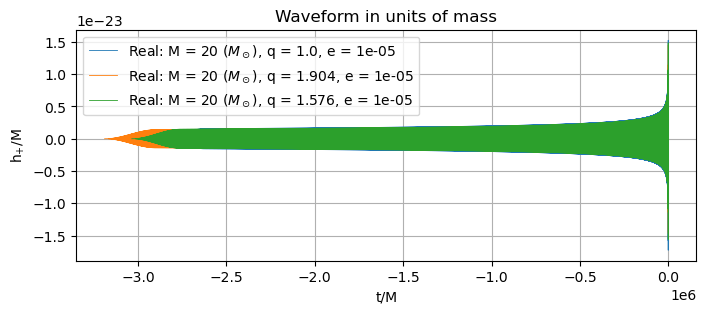

In [15]:
plot_Siminspiral_M_indp([20], [1.0, 1.904, 1.576], [1e-5])
plt.show()

### Waveform comparison

time GPU: 0.7946997900008379  minutes
Strain is calculated
time GPU: 1.2011422066667972  minutes
Strain is calculated
time GPU: 0.7819457500008866  minutes
Strain is calculated
time GPU: 0.7785314216666545  minutes
Strain is calculated
time GPU: 1.2015059116665119  minutes
Strain is calculated
time GPU: 0.77422819333345  minutes
Strain is calculated


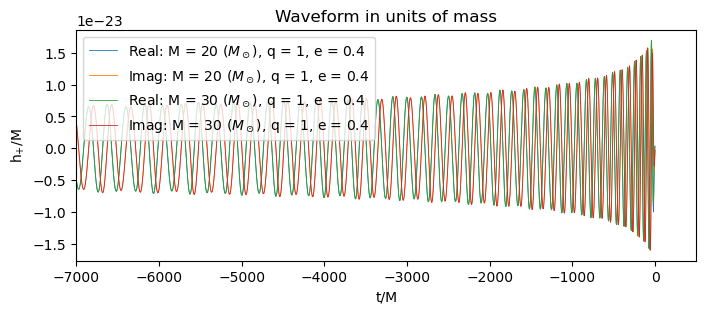

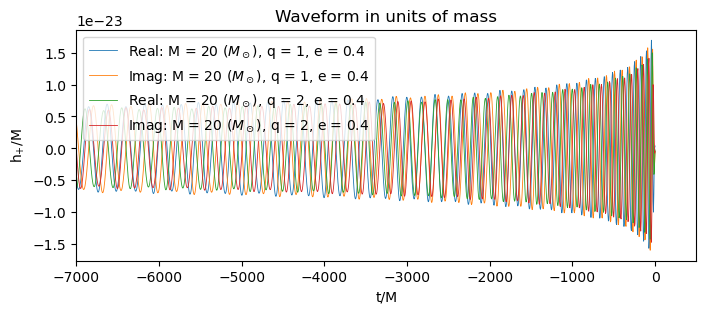

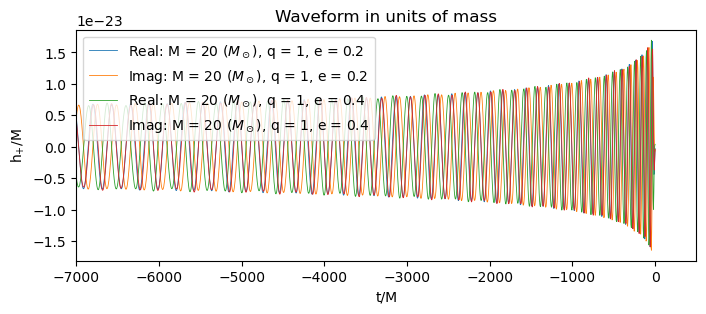

In [63]:
plot_Siminspiral_M_indp([20, 30], [1], [0.4])
plot_Siminspiral_M_indp([20], [1, 2], [0.4])
plot_Siminspiral_M_indp([20], [1], [0.2, 0.4])
plt.show()

Concluded from observation of GPU timer for different parameters:
- Higher eccentriricties have more cycles to mergers which results in longer inspiral times --> longer generation times
- Higher masses cause longer generation times so set M_total to a reasonably low value. M_total = 10
- Larger difference in mass ratio cause neglegible faster generation times, but does cause large irragularities to the waveform so set q = 1.

## Phase and amplitude difference for M_total = 10, q = 1

### Non-eccentric waveform and calculation of phase/amp difference

In [6]:
def circulair_wf(total_mass, mass_ratio):
    # Zero eccentricity
    hp_TS_circ, hc_TS_circ, t_M_circ = SimInspiral_M_independent(total_mass, mass_ratio, 1e-10)

    amp_circ = waveform.utils.amplitude_from_polarizations(hp_TS_circ, hc_TS_circ)
    phase_circ = waveform.utils.phase_from_polarizations(hp_TS_circ, hc_TS_circ)

    return amp_circ, phase_circ, t_M_circ

amp_circ, phase_circ, t_M_circ = circulair_wf(total_mass=10, mass_ratio=1) 


In [7]:

def phase_amplitude_wf(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ):
    # insert eccmin as list
    start = timer()
    
    hp_TS, hc_TS, t_M = SimInspiral_M_independent(total_mass, mass_ratio, eccmin)
    print('time : SimInspiral_M_independent ecc = {}'.format(eccmin), (timer()-start)/60, ' minutes')
    
    amp = waveform.utils.amplitude_from_polarizations(hp_TS, hc_TS)
    phase = waveform.utils.phase_from_polarizations(hp_TS, hc_TS) 
    
    # phase += phase[1]# Correct for the small drop on the start of the time-domain
    # phase = phase[1:] # First element was already zero before translation so cut of the first element
    # amp = amp[1:]
    # t_M = t_M[1:] # Be consistent with te time-domain
    
    
    # Correct or longer time till merger in circulair case
    diff = phase_circ[len(phase_circ) - len(phase)]
    phase_circ = phase_circ - diff
    phase_circ = phase_circ[len(phase_circ) - len(phase):]
    # print('PHASE CIRC:', phase_circ[0:10])
    

    # Phase difference 
    D_phase = np.zeros(len(phase))

    for i in range(len(t_M)):
        D_phase[i] = phase_circ[i] - phase[i]
        
    D_amp = np.zeros(len(amp))

    for i in range(len(t_M)):
        D_amp[i] = amp[i] - amp_circ[i]


    return phase, D_phase, amp, D_amp, t_M, phase_circ, amp_circ, t_M_circ


### Plot the phase and amplitude difference

In [47]:
def Plot_phase_amplitude(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ):

    phase, D_phase, amp, D_amp, hp_times, phase_circ, amp_circ, hp_circ_times = phase_amplitude_wf(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ)
    
    fig_phase_amp, axs = plt.subplots(4, 1, figsize=(12, 8))
    plt.subplots_adjust(hspace=0.5)

    
    axs[0].plot(hp_times, phase, label = 'M={}, q={}, e={}'.format(total_mass, mass_ratio, eccmin), linewidth=0.5)
    axs[0].plot(hp_times, phase_circ, label = 'M={}, q={}, e=0'.format(total_mass, mass_ratio), linewidth=0.5)
    # axs[0].plot(hp_times, phase_circ_short, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    axs[0].set_ylabel('$\phi_{22}$ [radians]')
    # axs[0].set_xlim(-1.780e7, -1.770e7)
    # axs[0].set_ylim(-1, 1)
    axs[0].set_xlabel('t [M]')
    axs[0].legend(loc='upper left')
    axs[0].grid()


    # # axs[1].plot(hp_circ_times, phase, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # axs[1].plot(hp_circ_times, phase_circ, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    # axs[1].set_ylabel('$\phi$ [radians]')
    # # axs[0].set_xlim(-10000, 0)
    # # axs[0].set_ylim(2000, 4000)
    # axs[1].set_xlabel('t [M]')
    # axs[1].legend(loc='upper left')
    
    axs[1].plot(hp_times, D_phase, linewidth=0.6)
    axs[1].set_ylabel('$\Delta\phi_{22}$ [radians]')
    # axs[1].set_xlim(-10000, 0)
    # axs[1].set_ylim(400, 700)
    axs[1].set_xlabel('t [M]')
    # axs[1].legend(loc='upper left')
    axs[1].grid()

    # axs[2].plot(hp_times, D_phase, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # axs[2].set_ylabel('$\Delta\phi$ [radians]')
    # axs[2].set_xlim(-400000, -380000)
    # axs[2].set_ylim(-1, 10)
    # axs[2].set_xlabel('t [M]')
    # axs[2].legend(loc='upper left')
    
    
    axs[2].plot(hp_times, amp, label = 'M={}, q={}, e={}'.format(total_mass, mass_ratio, eccmin), linewidth=0.5)
    # axs[2].plot(hp_circ_times, amp_circ, label = 'M={}, q={}, e=0'.format(total_mass, mass_ratio), linewidth=0.5)
    axs[2].set_ylabel('A$_{22}$')
    axs[2].set_xlim(-400000, 0)
    # axs[0][0].set_ylim(-6e-22, 6e-22)
    axs[2].set_xlabel('t [M]')
    axs[2].legend(loc='upper left')
    axs[2].grid()

    

    # # axs[2].plot(phase, amp, label = 'M={}, q={}, e={}, freqmin={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # # axs[2].set_ylabel('Amplitude')
    # # # axs[1].set_xlim(-20000, 0)
    # # # axs[0][0].set_ylim(-6e-22, 6e-22)
    # # axs[2].set_xlabel('Phase [radians]')
    # # axs[2].legend(loc='upper left')


    axs[3].plot(hp_times, D_amp, linewidth=0.5)
    axs[3].set_ylabel('$\Delta A_{22}$')
    # axs[1].set_xlim(-10000, 0)
    # axs[1].set_ylim(400, 700)
    axs[3].set_xlabel('t [M]')
    axs[3].grid()
    
    figname = 'phase22_Dphase22_negative.png'
    fig_phase_amp.savefig('Images/' + figname)

# Plot_phase_amplitude(10, 1, 0.01, amp_circ, phase_circ, t_M_circ)

time : SimInspiral_M_independent ecc = 0.01 0.9364421816666739  minutes


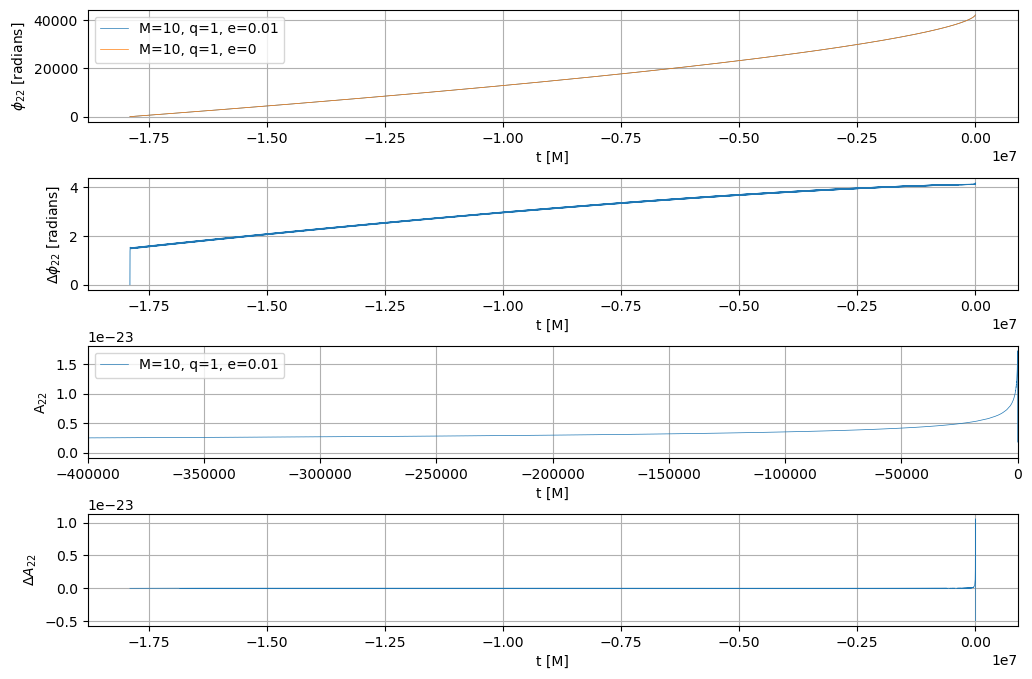

In [48]:
Plot_phase_amplitude(10, 1, 0.01, amp_circ, phase_circ, t_M_circ)

In [ ]:
Plot_phase_amplitude(10, 1, 0.01, amp_circ, phase_circ, t_M_circ)

### Drop in phase difference for low eccentricities (e =< 0.1))

time : SimInspiral_M_independent ecc = 0.1 0.5229278016666892  minutes


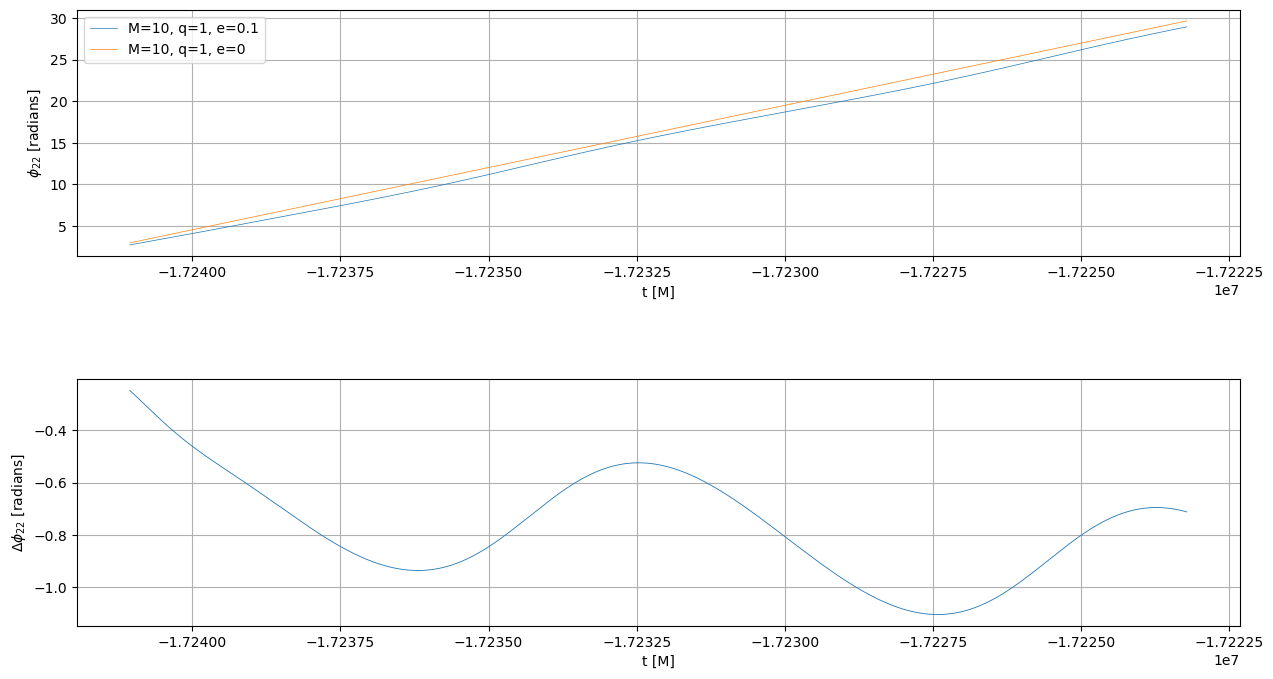

In [71]:
def Plot_phase_amplitude(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ):

    phase, D_phase, amp, D_amp, hp_times, phase_circ, amp_circ, hp_circ_times = phase_amplitude_wf(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ)

    fig_phase_amp, axs = plt.subplots(2, figsize=(15, 8))
    plt.subplots_adjust(hspace=0.5)

    
    axs[0].plot(hp_times[200:2000], phase[200:2000], label = 'M={}, q={}, e={}'.format(total_mass, mass_ratio, eccmin), linewidth=0.5)
    axs[0].plot(hp_times[200:2000], phase_circ[200:2000], label = 'M={}, q={}, e=0'.format(total_mass, mass_ratio), linewidth=0.5)
    # axs[0].plot(hp_times, phase_circ_short, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    axs[0].set_ylabel('$\phi_{22}$ [radians]')
    # axs[0].set_xlim(-1.780e7, -1.770e7)
    # axs[0].set_ylim(-1, 1)
    axs[0].set_xlabel('t [M]')
    axs[0].legend(loc='upper left')
    axs[0].grid()


    # # # axs[1].plot(hp_circ_times, phase, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # # axs[1].plot(hp_circ_times, phase_circ, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    # # axs[1].set_ylabel('$\phi$ [radians]')
    # # # axs[0].set_xlim(-10000, 0)
    # # # axs[0].set_ylim(2000, 4000)
    # # axs[1].set_xlabel('t [M]')
    # # axs[1].legend(loc='upper left')
    
    axs[1].plot(hp_times[200:2000], D_phase[200:2000], linewidth=0.6)
    axs[1].set_ylabel('$\Delta\phi_{22}$ [radians]')
    # axs[1].set_xlim(-10000, 0)
    # axs[1].set_ylim(400, 700)
    axs[1].set_xlabel('t [M]')
    axs[1].grid()
    # axs[1].legend(loc='upper left')

    # # axs[2].plot(hp_times, D_phase, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # # axs[2].set_ylabel('$\Delta\phi$ [radians]')
    # # axs[2].set_xlim(-400000, -380000)
    # # axs[2].set_ylim(-1, 10)
    # # axs[2].set_xlabel('t [M]')
    # # axs[2].legend(loc='upper left')
    
    
    # axs[2].plot(hp_times, amp, label = 'M={}, q={}, e={}'.format(total_mass, mass_ratio, eccmin), linewidth=0.5)
    # # axs[2].plot(hp_circ_times, amp_circ, label = 'M={}, q={}, e=0'.format(total_mass, mass_ratio), linewidth=0.5)
    # axs[2].set_ylabel('A$_{22}$')
    # axs[2].set_xlim(-400000, 0)
    # # axs[0][0].set_ylim(-6e-22, 6e-22)
    # axs[2].set_xlabel('t [M]')
    # axs[2].legend(loc='upper left')

    

    # # axs[2].plot(phase, amp, label = 'M={}, q={}, e={}, freqmin={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # # axs[2].set_ylabel('Amplitude')
    # # # axs[1].set_xlim(-20000, 0)
    # # # axs[0][0].set_ylim(-6e-22, 6e-22)
    # # axs[2].set_xlabel('Phase [radians]')
    # # axs[2].legend(loc='upper left')


    # axs[3].plot(hp_times, D_amp, linewidth=0.5)
    # axs[3].set_ylabel('$\Delta A_{22}$')
    # # axs[1].set_xlim(-10000, 0)
    # # axs[1].set_ylim(400, 700)
    # axs[3].set_xlabel('t [M]')
    figname = 'phase22_Dphase22_start_cutoff.png'
    fig_phase_amp.savefig('Images/' + figname)

Plot_phase_amplitude(10, 1, 0.1, amp_circ, phase_circ, t_M_circ)

time : SimInspiral_M_independent ecc = 0.1 0.4608794900000551  minutes
index D_phase:  0.0
index D_phase:  -0.11804632904802226
index D_phase:  -0.24777797828809245
index D_phase:  -0.45020062480248235
index D_phase:  -0.6056391259540179
index D_phase:  -0.7618161431241379
index D_phase:  -0.8905123996699604
index D_phase:  -0.9354747490646993
index D_phase:  -0.8603277514584722
index D_phase:  -0.6934776035497272
last part of D_phase:  [   0.            0.74515507    0.73349403 ... -256.7340123  -256.73196689
 -256.73057129]


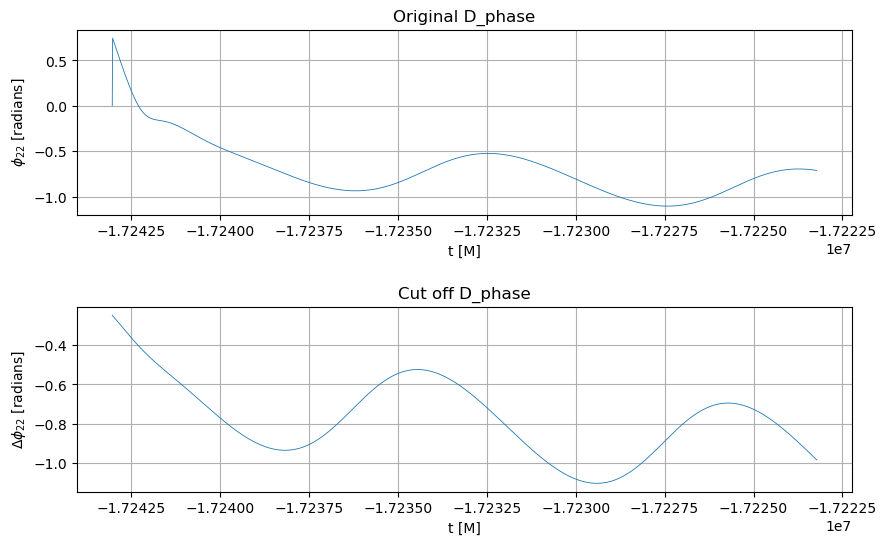

In [69]:
def Plot_phase_amplitude(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ):

    phase, D_phase, amp, D_amp, hp_times, phase_circ, amp_circ, hp_circ_times = phase_amplitude_wf(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ)
    
    for i in range(1000):
        if i % 100 == 0:
            print('index D_phase: ', D_phase[i])
    # print('start of cut-off D-phase:', D_phase[400:450])
    print('last part of D_phase: ', D_phase[:-100])
    
    fig_phase_amp, axs = plt.subplots(2, 1, figsize=(10, 6))
    plt.subplots_adjust(hspace=0.5)

    
    axs[0].plot(hp_times[0:2000], D_phase[0:2000], linewidth=0.6)
    # axs[0].plot(hp_times, phase_circ_short, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    axs[0].set_ylabel('$\phi_{22}$ [radians]')
    # axs[0].set_xlim(-1.780e7, -1.770e7)
    # axs[0].set_ylim(-1, 1)
    axs[0].set_xlabel('t [M]')
    axs[0].set_title('Original D_phase')
    axs[0].grid()

    D_phase = D_phase[200:-100]
    axs[1].plot(hp_times[0:2000], D_phase[0:2000], linewidth=0.6)

    axs[1].set_ylabel('$\Delta\phi_{22}$ [radians]')
    # axs[1].set_xlim(-10000, 0)
    # axs[1].set_ylim(400, 700)
    axs[1].set_xlabel('t [M]')
    axs[1].set_title('Cut off D_phase')
    axs[1].grid()

    figname = 'phase22_Dphase22.png'
    fig_phase_amp.savefig('Images/' + figname)

Plot_phase_amplitude(10, 1, 0.1, amp_circ, phase_circ, t_M_circ)

From the plots it can be seen that there's a small drop in phase at the beginning of the time-domain. There's also a small drop at the end of the time-domain. To fix this problem I'll cut off the troubled parts at the start and end. Use the range **D_phase[200:-100]**

# Building the dataset

## Dataset for low eccentricities e = [0,1]

### Generate dataset for different eccentricities

In [5]:
def phase_amp_diff(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ):
    phase, D_phase, amp, D_amp, hp_times, phase_circ, amp_circ, hp_circ_times = phase_amplitude_wf(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ)

    return D_phase, D_amp, hp_times



In [10]:
# fig_change, axs = plt.subplots(2, figsize=(10, 6))
# plt.subplots_adjust(hspace=0.4)

# Build dataset for different eccentricities
# list of 20 evenly spaced values between 0 and 0.1. All rounded at 2 decimals.
eccmin = np.linspace(0.01, 0.1, 20).round(3)
print(eccmin)

# Different eccentricities cause different inspiral-times. Cut off the first part of every waveform so all waveforms have same length
D_phase, D_amp, t_M_short = phase_amp_diff(10, 1, np.max(eccmin), amp_circ, phase_circ, t_M_circ) # Highest eccentricity causes shortest inspiral-time.

# Cut off the first part (See section before about the drops)
t_M_short = t_M_short[200:]

[0.01  0.015 0.019 0.024 0.029 0.034 0.038 0.043 0.048 0.053 0.057 0.062
 0.067 0.072 0.076 0.081 0.086 0.091 0.095 0.1  ]
time : SimInspiral_M_independent ecc = 0.1 0.4821217200000016  minutes


In [11]:
# Make empty arrays to fill the complete dataset
D_phase_ds, D_amp_ds, t_M_ds, eccmin_ds = np.zeros((len(eccmin), len(t_M_short))), np.zeros((len(eccmin), len(t_M_short))), np.zeros((len(eccmin), len(t_M_short))), np.zeros((len(eccmin), len(t_M_short)))

# Fill the last column with highest eccentricity 0.1
for i in range(len(t_M_short)): 
    D_phase_ds[-1][i] = D_phase[i]
    D_amp_ds[-1][i] = D_amp[i]
    t_M_ds[-1][i] = t_M_short[i]
    
print(D_phase_ds[-1])

[  0.          -0.74515507  -0.73349403 ... 256.68240444 256.68539052
 256.68861763]


In [12]:
print(eccmin[:5])
# Load first 5 eccentricities. Not all at once because of maximum memory error.
for wf_count, ecc in enumerate(eccmin[:5]):

    D_phase, D_amp, t_M = phase_amp_diff(10, 1, ecc, amp_circ, phase_circ, t_M_circ)
    length_diff = len(t_M) - len(t_M_short)

    # Cut off to match lengths with shortest waveform (e = 0.1)
    D_phase = D_phase[-len(t_M_short):]
    D_amp = D_amp[-len(t_M_short):]
    t_M = t_M[-len(t_M_short):]
    
    
    for i in range(len(t_M)): 

        D_phase_ds[wf_count][i] = D_phase[i]
        D_amp_ds[wf_count][i] = D_amp[i]
        t_M_ds[wf_count][i] = t_M[i]


[0.01  0.015 0.019 0.024 0.029]
time : SimInspiral_M_independent ecc = 0.01 0.5558734850000008  minutes
time : SimInspiral_M_independent ecc = 0.015 0.4404613516666662  minutes
time : SimInspiral_M_independent ecc = 0.019 0.6517638850000007  minutes
time : SimInspiral_M_independent ecc = 0.024 0.41428244499999967  minutes
time : SimInspiral_M_independent ecc = 0.029 0.4562484783333332  minutes


In [13]:
print(eccmin[5:10])
# Load next 5 eccentricities of eccmin range
for wf_count, ecc in enumerate(eccmin[5:10]):

    D_phase, D_amp, t_M = phase_amp_diff(10, 1, ecc, amp_circ, phase_circ, t_M_circ)
    length_diff = len(t_M) - len(t_M_short)

    # Cut off to match lengths with shortest waveform (e = 0.1)
    D_phase = D_phase[-len(t_M_short):]
    D_amp = D_amp[-len(t_M_short):]
    t_M = t_M[-len(t_M_short):]
    
    
    for i in range(len(t_M)): 

        D_phase_ds[wf_count + 5][i] = D_phase[i] # + 5 so wf_count starts from 5
        D_amp_ds[wf_count + 5][i] = D_amp[i]
        t_M_ds[wf_count + 5][i] = t_M[i]

[0.034 0.038 0.043 0.048 0.053]
time : SimInspiral_M_independent ecc = 0.034 0.40645169833333433  minutes
time : SimInspiral_M_independent ecc = 0.038 0.40677463999999947  minutes
time : SimInspiral_M_independent ecc = 0.043 0.3656970683333327  minutes
time : SimInspiral_M_independent ecc = 0.048 0.47867178000000005  minutes
time : SimInspiral_M_independent ecc = 0.053 0.36364629000000076  minutes


In [14]:
print(eccmin[10:15])
# Load next 5 eccentricities of eccmin range
for wf_count, ecc in enumerate(eccmin[10:15]):

    D_phase, D_amp, t_M = phase_amp_diff(10, 1, ecc, amp_circ, phase_circ, t_M_circ)
    length_diff = len(t_M) - len(t_M_short)

    # Cut off to match lengths with shortest waveform (e = 0.1)
    D_phase = D_phase[-len(t_M_short):]
    D_amp = D_amp[-len(t_M_short):]
    t_M = t_M[-len(t_M_short):]
    
    
    for i in range(len(t_M)): 

        D_phase_ds[wf_count + 10][i] = D_phase[i] # + 5 so wf_count starts from 5
        D_amp_ds[wf_count + 10][i] = D_amp[i]
        t_M_ds[wf_count + 10][i] = t_M[i]


[0.057 0.062 0.067 0.072 0.076]
time : SimInspiral_M_independent ecc = 0.057 0.39917445333333224  minutes
time : SimInspiral_M_independent ecc = 0.062 0.40818802333333226  minutes
time : SimInspiral_M_independent ecc = 0.067 0.5123297966666656  minutes
time : SimInspiral_M_independent ecc = 0.072 0.8313840049999991  minutes
time : SimInspiral_M_independent ecc = 0.076 0.4648980800000004  minutes


In [15]:
print(eccmin[15:-1])
# Load last 4 eccentricities of eccmin range
for wf_count, ecc in enumerate(eccmin[15:-1]):

    D_phase, D_amp, t_M = phase_amp_diff(10, 1, ecc, amp_circ, phase_circ, t_M_circ)
    length_diff = len(t_M) - len(t_M_short)

    # Cut off to match lengths with shortest waveform (e = 0.1)
    D_phase = D_phase[-len(t_M_short):]
    D_amp = D_amp[-len(t_M_short):]
    t_M = t_M[-len(t_M_short):]
    
    
    for i in range(len(t_M)): 

        D_phase_ds[wf_count + 15][i] = D_phase[i] # + 5 so wf_count starts from 5
        D_amp_ds[wf_count + 15][i] = D_amp[i]
        t_M_ds[wf_count + 15][i] = t_M[i]

[0.081 0.086 0.091 0.095]
time : SimInspiral_M_independent ecc = 0.081 0.3519515133333319  minutes
time : SimInspiral_M_independent ecc = 0.086 0.452946611666664  minutes
time : SimInspiral_M_independent ecc = 0.091 0.47280412500000085  minutes
time : SimInspiral_M_independent ecc = 0.095 0.4703428833333343  minutes


In [16]:
print(D_phase_ds[0], len(D_phase_ds[:,1]))

[1.62985193 1.63000901 1.63016557 ... 4.16438506 4.16717759 4.17062937] 20


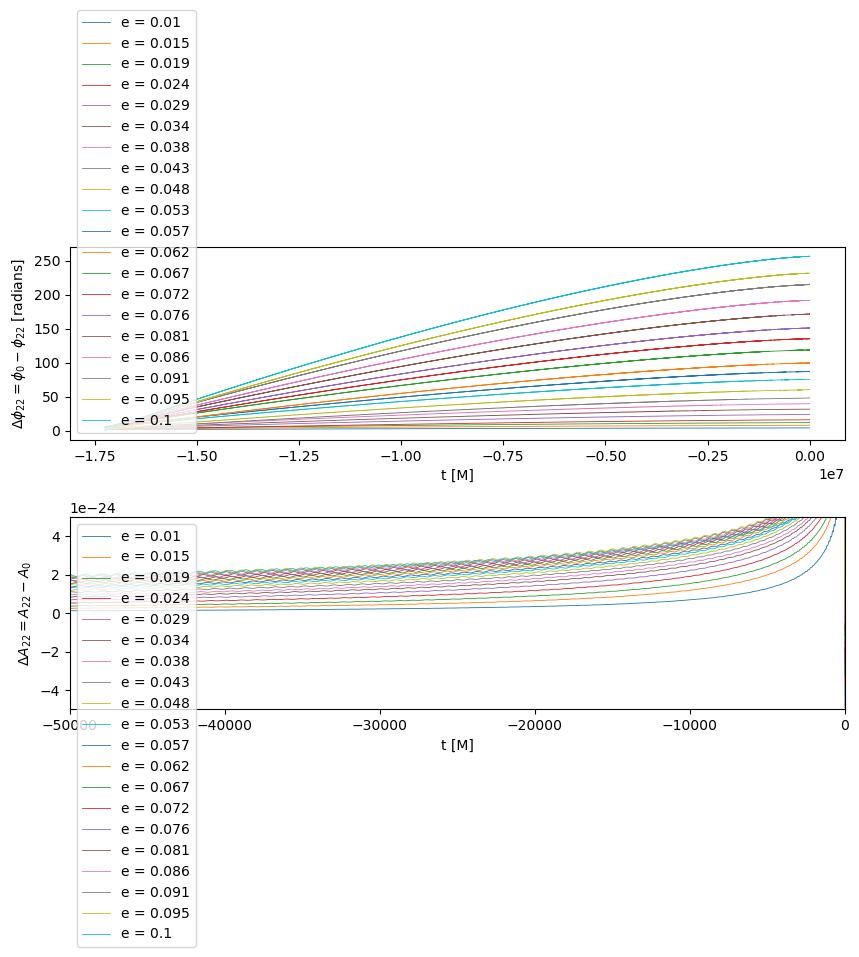

In [17]:


fig_dataset, axs = plt.subplots(2, figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)


for i in range(len(D_phase_ds)):
    axs[0].plot(t_M_ds[i], D_phase_ds[i], linewidth=0.6, label = 'e = {}'.format(eccmin[i]))
    axs[0].set_xlabel('t [M]')
    axs[0].set_ylabel('$\Delta\phi_{22} = \phi_0 - \phi_{22}$ [radians]')
    # axs[0].set_xlim(-50000, 0)
    axs[0].legend(loc = 'lower left')
    
    axs[1].plot(t_M_ds[i], D_amp_ds[i], linewidth=0.6, label = 'e = {}'.format(eccmin[i]))
    axs[1].set_ylabel('$\Delta A_{22} = A_{22} - A_0$')
    axs[1].set_ylim(-0.5e-23, 0.5e-23)
    axs[1].set_xlim(-50000, 0)
    axs[1].set_xlabel('t [M]')
    axs[1].legend(loc = 'upper left')  

plt.show()

### Save dataset in txt file

In [18]:
header = str(1)
print(header)

1


In [19]:
header = str(eccmin)

np.savetxt('Straindata/SimInspiral_t_M_lowecc_0.01_0.1.txt', t_M_ds, header=header)
np.savetxt('Straindata/SimInspiral_Dphase_lowecc_0.01_0.1.txt', D_phase_ds, header=header)
np.savetxt('Straindata/SimInspiral_Damp_lowecc_0.01_0.1.txt', D_amp_ds, header=header)


### Extract dataset from txt file

#### Dataset of 20 wfs for $e \in [0.01, 0.5]$

In [98]:
# Read data from the text file
t_M_read = np.loadtxt('Straindata/SimInspiral_t_M_highecc_0.01_0.5.txt', skiprows=1)
D_phase_read = np.loadtxt('Straindata/SimInspiral_Dphase_highecc_0.01_0.5.txt', skiprows=1)
D_amp_read = np.loadtxt('Straindata/SimInspiral_Damp_highecc_0.01_0.5.txt', skiprows=1)

eccmin = np.linspace(0.01, 0.5, 20).round(3)
print(eccmin)

print(D_phase_read[0], len(D_phase_read[:,1]))

# Normalise whole dataset
D_phase_read = D_phase_read / np.linalg.norm(D_phase_read)
D_amp_read = D_amp_read / np.linalg.norm(D_amp_read)


# Normalise each vector within dataset
D_phase_read = D_phase_read / np.linalg.norm(D_phase_read, axis=1, keepdims=True)
D_amp_read = D_amp_read / np.linalg.norm(D_amp_read, axis=1, keepdims=True)


[0.01  0.036 0.062 0.087 0.113 0.139 0.165 0.191 0.216 0.242 0.268 0.294
 0.319 0.345 0.371 0.397 0.423 0.448 0.474 0.5  ]
[3.53852353 3.53855509 3.53858451 ... 4.16438506 4.16717759 4.17062937] 20


#### Dataset of 20 wfs for $e \in [0.01, 0.21]$

In [2]:
# Read data from the text file
t_M_read = np.loadtxt('Straindata/SimInspiral_t_M_lowecc_0.2.txt', skiprows=1)
D_phase_read = np.loadtxt('Straindata/SimInspiral_Dphase_lowecc_0.2.txt', skiprows=1)
D_amp_read = np.loadtxt('Straindata/SimInspiral_Damp_lowecc_0.2.txt', skiprows=1)

eccmin = np.linspace(0.01, 0.21, 20).round(3)
print(eccmin)

# Normalise whole dataset
D_phase_read = D_phase_read / np.linalg.norm(D_phase_read)
D_amp_read = D_amp_read / np.linalg.norm(D_amp_read)


# Normalise each vector within dataset
D_phase_read = D_phase_read / np.linalg.norm(D_phase_read, axis=1, keepdims=True)
D_amp_read = D_amp_read / np.linalg.norm(D_amp_read, axis=1, keepdims=True)


[0.01  0.021 0.031 0.042 0.052 0.063 0.073 0.084 0.094 0.105 0.115 0.126
 0.136 0.147 0.157 0.168 0.178 0.189 0.199 0.21 ]


#### Dataset of 20 wfs for $e \in [0.3, 0.5]$

In [29]:
# Read data from the text file
t_M_read = np.loadtxt('Straindata/SimInspiral_t_M_highecc.txt', skiprows=1)
D_phase_read = np.loadtxt('Straindata/SimInspiral_Dphase_highecc.txt', skiprows=1)
D_amp_read = np.loadtxt('Straindata/SimInspiral_Damp_highecc.txt', skiprows=1)

eccmin = np.linspace(0.3, 0.5, 20).round(3)


# Normalise whole dataset
D_phase_read = D_phase_read / np.linalg.norm(D_phase_read)
D_amp_read = D_amp_read / np.linalg.norm(D_amp_read)

# Normalise each vector within dataset
D_phase_read = D_phase_read / np.linalg.norm(D_phase_read, axis=1, keepdims=True)
D_amp_read = D_amp_read / np.linalg.norm(D_amp_read, axis=1, keepdims=True)


#### Dataset of 20 wfs for $e \in [0, 0.1]$ (faulty?)

In [20]:
# Read data from the text file
t_M_read = np.loadtxt('Straindata/SimInspiral_t_M_lowecc_0.01_0.1.txt', skiprows=1)
D_phase_read = np.loadtxt('Straindata/SimInspiral_Dphase_lowecc_0.01_0.1.txt', skiprows=1)
D_amp_read = np.loadtxt('Straindata/SimInspiral_Damp_lowecc_0.01_0.1.txt', skiprows=1)

eccmin = np.linspace(0.01, 0.1, 20).round(3)
print(eccmin)


# Normalise whole dataset
D_phase_read = D_phase_read / np.linalg.norm(D_phase_read)
D_amp_read = D_amp_read / np.linalg.norm(D_amp_read)


# Normalise each vector within dataset
D_phase_read = D_phase_read / np.linalg.norm(D_phase_read, axis=1, keepdims=True)
D_amp_read = D_amp_read / np.linalg.norm(D_amp_read, axis=1, keepdims=True)


[0.01  0.015 0.019 0.024 0.029 0.034 0.038 0.043 0.048 0.053 0.057 0.062
 0.067 0.072 0.076 0.081 0.086 0.091 0.095 0.1  ]


In [27]:
print(D_phase_read[0][:30])

[-0.8167548  -0.81674547 -0.81673603 -0.81672649 -0.81671685 -0.8167071
 -0.81669725 -0.8166873  -0.81667724 -0.81666709 -0.81665683 -0.81664647
 -0.81663601 -0.81662545 -0.8166148  -0.81660404 -0.81659319 -0.81658224
 -0.81657119 -0.81656005 -0.81654881 -0.81653748 -0.81652605 -0.81651453
 -0.81650292 -0.81649121 -0.81647941 -0.81646752 -0.81645554 -0.81644347]


#### Test dataset of 10 wfs for $e \in [0, 0.1]$

In [13]:
# Read data from the text file
t_M_read = np.loadtxt('Straindata/SimInspiral_t_M_test.txt')
D_phase_read = np.loadtxt('Straindata/SimInspiral_Dphase_test.txt')
D_amp_read = np.loadtxt('Straindata/SimInspiral_Damp_test.txt')

eccmin = np.linspace(0.01, 0.1, 10).round(2)
print(eccmin)

# Normalise whole dataset
D_phase_read = D_phase_read / np.linalg.norm(D_phase_read)
D_amp_read = D_amp_read / np.linalg.norm(D_amp_read)

# Normalise each vector within dataset
D_phase_read = D_phase_read / np.linalg.norm(D_phase_read, axis=1, keepdims=True)
D_amp_read = D_amp_read / np.linalg.norm(D_amp_read, axis=1, keepdims=True)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]


In [34]:
print(D_phase_read.shape, np.min(t_M_read[0]))


(20, 1526125) -15129004.24133056


#### Plotting the dataset

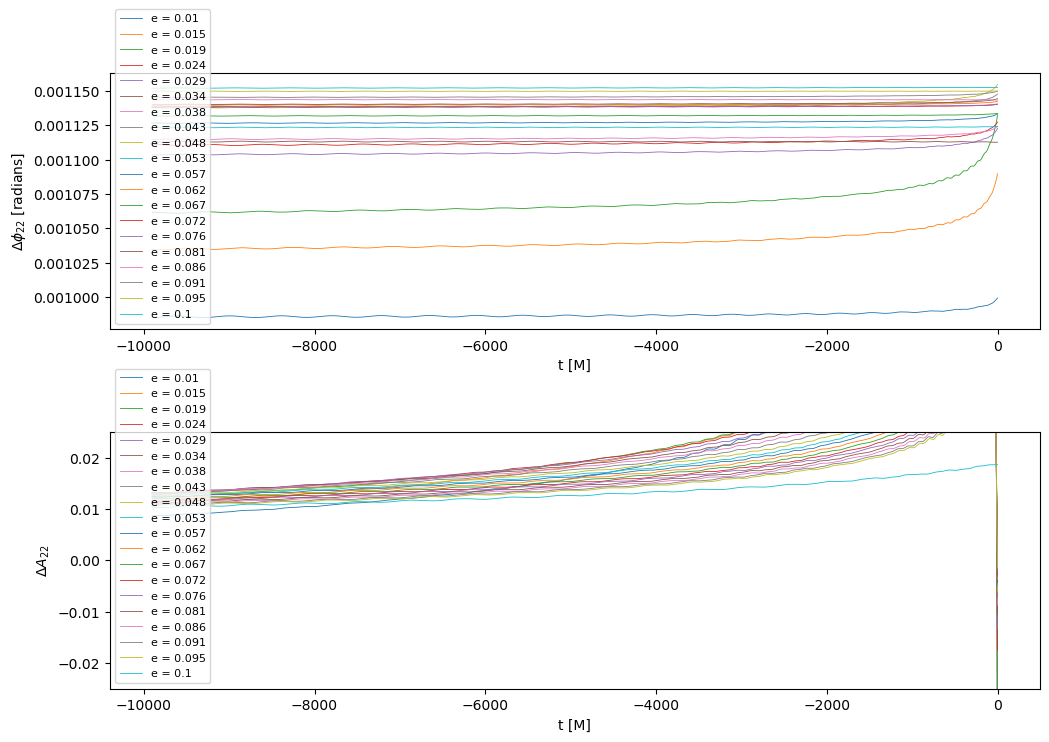

In [38]:
fig_dataset_ecc, axs = plt.subplots(2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4)
                                           

for i in range(len(t_M_read)):
    axs[0].plot(t_M_read[i][-1000:], D_phase_read[i][-1000:], label = 'e = {}'.format(eccmin[i]), linewidth=0.6)
    axs[0].set_xlabel('t [M]')
    axs[0].set_ylabel('$\Delta\phi_{22}$ [radians]')
    axs[0].grid()
    # axs[0].set_xlim(-20000, 0)
    # axs[0].set_ylim(0, 0.00075)
    axs[0].legend(loc = 'lower left', fontsize=8)
    
    axs[1].plot(t_M_read[i][-1000:], D_amp_read[i][-1000:], label = 'e = {}'.format(eccmin[i]), linewidth=0.6)
    axs[1].set_ylabel('$\Delta A_{22}$')
    # axs[1].set_ylim(-0.5e-23, 0.5e-23)
    
    # axs[1].set_xlim(-20000, 0)
    axs[1].set_ylim(-0.025, 0.025)
    axs[1].set_xlabel('t [M]')
    axs[1].grid()
    axs[1].legend(loc = 'lower left', fontsize=8)
    
    figname = 'Dphase22_Damp22_TSnorm.png'
    fig_dataset_ecc.savefig('Images/' + figname)

    
plt.show()

To calculate the greedy errors we first need to transform the dataset and make it **orthonormal** (each waveform in it's own needs to be normalised). If every waveform has unit length, the phase and amplitude of the waveforms will have an intersectionpoint.

In [69]:
print(np.linalg.norm(D_amp_read, axis=1, keepdims=True))

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


# Reduced basis and greedy Error

### Greedy error following https://arxiv.org/abs/1308.3565 Algorithm 1

In [35]:

def greedy_algorithm(parameter_space, waveforms, treshold_error):
    # Import parameter space (N x 1) and waveforms (N x T)as array type. Where N is the amound of waveforms and T the length of the time-array.
    # print(waveforms.shape, parameter_space.shape)

    # normalized_wfs = waveforms / np.linalg.norm(waveforms, axis=1, keepdims=True)
    normalized_wfs = waveforms
    
    num_waveforms = waveforms.shape[0]
    m = 0  # Initialize the counter for the number of reduced basis waveforms
    reduced_basis = np.zeros((waveforms.shape[1], num_waveforms))
    greedy_points = np.zeros((num_waveforms, parameter_space.shape[1]))
  
    #Randomly select the first waveform as the initial guess
    idx = np.random.choice(num_waveforms)
    reduced_basis[:, m] = normalized_wfs[idx]
    # print(normalized_wfs.shape)
    greedy_points[m, :] = parameter_space[idx]

    
    greedy_error = 1
    greedy_error_list = [[1, greedy_error]]

    projections = [0]
    
    while greedy_error >= treshold_error:
        projection = 0
        
        for i in range(0, m + 1):
            # Calculate the projection coefficients for each waveform onto the current reduced basis
            coeffs = np.dot(normalized_wfs, reduced_basis[:, i:i+1])
                
            # Calculate the residual for each waveform
            projection += coeffs*reduced_basis[:, i:i+1].T
        projections.append(projection)
        residual = np.subtract(normalized_wfs, projection)
        # print(projection.shape)

        # Find the index of the waveform that maximally contributes to the current residual
        idx = np.argmax(np.linalg.norm(residual, axis=1))

        # # Extract the selected waveform and add it to the reduced basis
        m += 1
        # print('\nm:', m)
        normalized_residual = residual[idx] / np.linalg.norm(residual[idx])
        # print(residual, normalized_residual, residual.shape, normalized_residual.shape)
        reduced_basis[:, m] = normalized_residual


        # Update the greedy points matrix
        greedy_points[m, :] = parameter_space[idx]

        # # Check if the target representation accuracy is achieved
        greedy_error = np.max(np.linalg.norm(residual, axis=0))
        greedy_error_list.append([m+1, greedy_error])
        print(greedy_error)


        if m == 9:
            break
        
    return reduced_basis[:, :m+1], greedy_points[:m+1, :], greedy_error_list, projections
                            

In [123]:
eccmin = np.array(eccmin)
eccmin = eccmin.reshape((eccmin.shape[0], 1))

reduced_basis, greedy_points, greedy_error, projections = greedy_algorithm(eccmin, D_phase_read, 1e-12)

(1739176, 10)
(1739176, 10)
0.0004451615807433415
4.239215282511903e-05
2.2879959503269842e-05
1.9838652276589687e-05
1.9025003151819854e-05
1.0175208737696847e-05
5.496153532304039e-06
5.755695598182103e-06
5.286674235053897e-06


(10, 1739176)


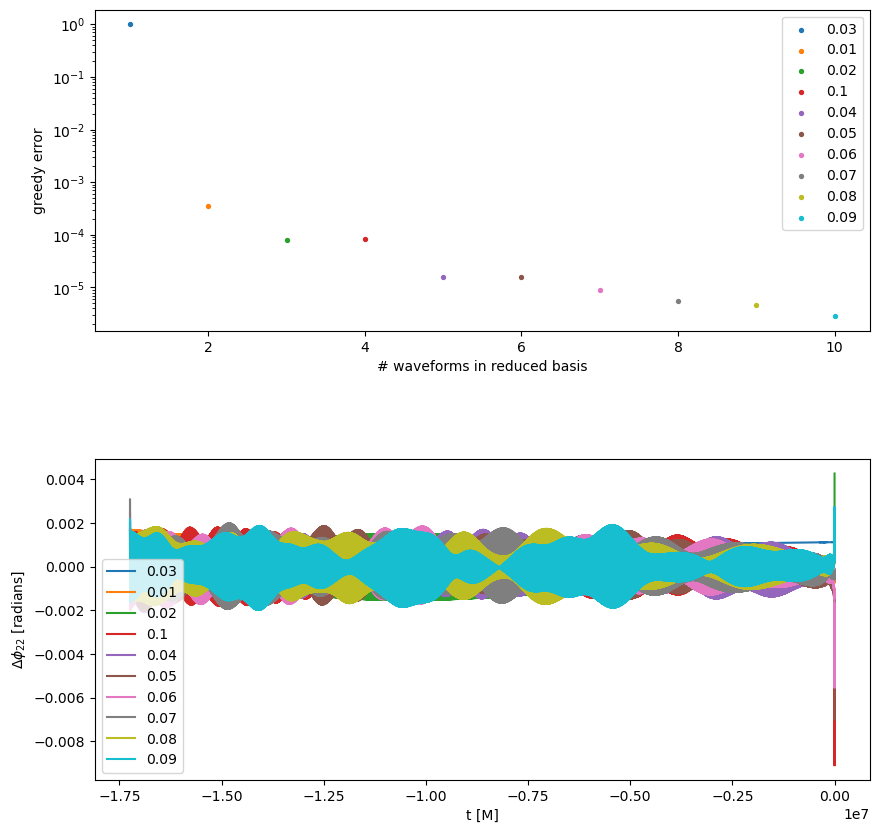

In [26]:
fig_RB, axs = plt.subplots(2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)
print(D_phase_read.shape)


for i in range(len(greedy_points)):
    # print(greedy_error[i][0], greedy_error[i][1])
    axs[0].scatter(greedy_error[i][0], greedy_error[i][1], s = 8, label = greedy_points[i][0])
    axs[0].plot(greedy_error[i][0], greedy_error[i][1])
    axs[0].set_xlabel('# waveforms in reduced basis')
    axs[0].set_ylabel('greedy error')
    axs[0].set_yscale('log')
    axs[0].legend(loc = 'upper right')

    axs[1].plot(t_M_read[i], reduced_basis[:, i], label = greedy_points[i][0])
    axs[1].set_xlabel('t [M]')
    axs[1].set_ylabel('$\Delta\phi_{22}$ [radians]')
    axs[1].legend(loc = 'lower left')
    # axs[1].set_ylim(0, 0.00005)
    # axs[1].set_xlim(-3.5e6, -4e6)
    figname = 'Dphase22_greedy_error_RB.png'
    fig_RB.savefig('Images/' + figname)

[[0.03]
 [0.01]
 [0.02]
 [0.1 ]
 [0.04]
 [0.05]
 [0.06]
 [0.07]
 [0.08]
 [0.09]] [[1, 1], [2, 0.0003537623827043031], [3, 7.838398703296662e-05], [4, 8.256328693681897e-05], [5, 1.6141788901364408e-05], [6, 1.592487278936361e-05], [7, 8.831207928337619e-06], [8, 5.46270397668724e-06], [9, 4.688071461858376e-06], [10, 2.8753406980327762e-06]]


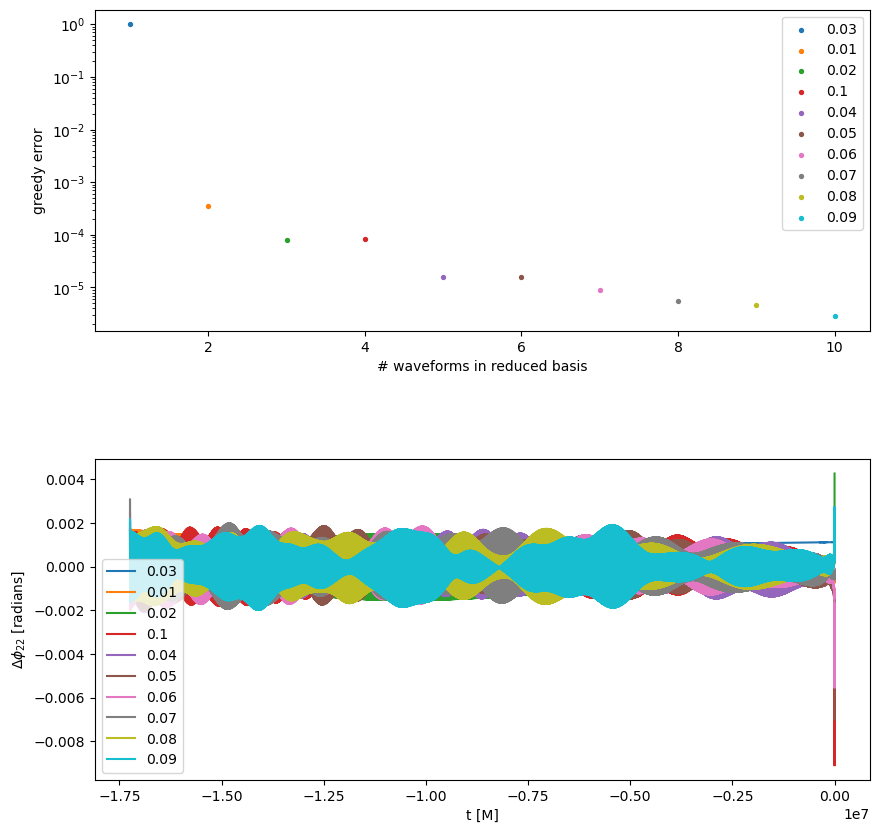

In [22]:
fig_RB, axs = plt.subplots(2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)
print(greedy_points, greedy_error)


for i in range(len(greedy_points)):
    # print(greedy_error[i][0], greedy_error[i][1])
    axs[0].scatter(greedy_error[i][0], greedy_error[i][1], s = 8, label = greedy_points[i][0])
    axs[0].plot(greedy_error[i][0], greedy_error[i][1])
    axs[0].set_xlabel('# waveforms in reduced basis')
    axs[0].set_ylabel('greedy error')
    axs[0].set_yscale('log')
    axs[0].legend(loc = 'upper right')

    axs[1].plot(t_M_read[i], reduced_basis[:, i], label = greedy_points[i][0])
    axs[1].set_xlabel('t [M]')
    axs[1].set_ylabel('$\Delta\phi_{22}$ [radians]')
    axs[1].legend(loc = 'lower left')
    # axs[1].set_ylim(0, 0.00005)
    # axs[1].set_xlim(-3.5e6, -4e6)

### Testing the greedy algorithm

In [19]:
# Parameterspace for testing the greedy algorihtm. Test for parameter space q = {1, ..., 2}
q = np.array([1.0, 1.904, 1.576, 2.0, 1.35, 1.75, 1.204, 1.27, 1.966, 1.468, 1.484])
print(np.argmin(q))


hp_TS, hc_TS, t_short = SimInspiral_M_independent(total_mass=20, mass_ratio=np.min(q), eccmin=1e-5) # Lowest mass ratio causes shortest inspiral-time.
# Cut off the first part (See section before about the drops)
t_short = t_short[200:]
print(len(t_short), np.min(q))

hp_TS_ds, hc_TS_ds, t_ds = np.zeros((len(q), len(t_short))), np.zeros((len(q), len(t_short))), np.zeros((len(q), len(t_short)))

# Fill the last column with highest eccentricity 0.1
for i in range(len(t_short)): 
    hp_TS_ds[np.argmin(q)][i] = hp_TS[i]
    hc_TS_ds[np.argmin(q)][i] = hc_TS[i]
    t_ds[np.argmin(q)][i] = t_short[i]



0
582386 1.0


In [20]:
print(q[1:5])
for wf_count, q_value in enumerate(q[1:5]):
    # Mass independent waveform polarizations
    hp_TS, hc_TS, t = SimInspiral_M_independent(total_mass=20, mass_ratio=q_value, eccmin=1e-5)

    length_diff = len(t) - len(t_short)

    # Cut off to match lengths with shortest waveform (q = 1.0)
    print(len(t_short), len(t), q_value)
    hp_TS = hp_TS[length_diff:]
    hc_TS = hc_TS[length_diff:]
    t = t[length_diff:]
    
    
    for i in range(len(t)): 

        hp_TS_ds[wf_count + 1][i] = hp_TS[i]
        hc_TS_ds[wf_count + 1][i] = hc_TS[i]
        t_ds[wf_count + 1][i] = t[i]


print(hp_TS_ds)

[1.904 1.576 2.    1.35 ]
582386 643486 1.904
582386 612456 1.576
582386 653531 2.0
582386 595461 1.35
[[ 0.00000000e+00  1.07517220e-33  4.26601779e-33 ...  4.70985292e-24
   6.90401396e-24  8.64105036e-24]
 [ 1.35174416e-24  1.34553804e-24  1.33902656e-24 ... -1.87935238e-24
  -1.73126046e-24 -4.89285950e-25]
 [-1.30381883e-25 -1.18391853e-25 -1.06374728e-25 ...  7.83316904e-25
  -9.35139608e-25 -4.92698212e-25]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [21]:
print(q[5:])

for wf_count, q_value in enumerate(q[5:]):
    print(wf_count)
    # Mass independent waveform polarizations
    hp_TS, hc_TS, t = SimInspiral_M_independent(total_mass=20, mass_ratio=q_value, eccmin=1e-5)

    length_diff = len(t) - len(t_short)

    # Cut off to match lengths with shortest waveform (q = 1.0)
    print(len(t_short), len(t), q_value)
    hp_TS = hp_TS[length_diff:]
    hc_TS = hc_TS[length_diff:]
    t = t[length_diff:]
    
    
    for i in range(len(t)): 

        hp_TS_ds[wf_count + 5][i] = hp_TS[i]
        hc_TS_ds[wf_count + 5][i] = hc_TS[i]
        t_ds[wf_count + 5][i] = t[i]

print(hp_TS_ds)

[1.75  1.204 1.27  1.966 1.468 1.484]
0
582386 628193 1.75
1
582386 587490 1.204
2
582386 590730 1.27
3
582386 649934 1.966
4
582386 603755 1.468
5
582386 604983 1.484
[[ 0.00000000e+00  1.07517220e-33  4.26601779e-33 ...  4.70985292e-24
   6.90401396e-24  8.64105036e-24]
 [ 1.35174416e-24  1.34553804e-24  1.33902656e-24 ... -1.87935238e-24
  -1.73126046e-24 -4.89285950e-25]
 [-1.30381883e-25 -1.18391853e-25 -1.06374728e-25 ...  7.83316904e-25
  -9.35139608e-25 -4.92698212e-25]
 ...
 [-1.25832355e-24 -1.24890488e-24 -1.23920064e-24 ... -2.15787868e-25
  -1.25662110e-24 -4.98069754e-25]
 [ 4.33364689e-25  4.36573267e-25  4.39687978e-25 ... -1.84487339e-24
   4.29268479e-25  4.17965853e-25]
 [-4.83349551e-25 -4.86611203e-25 -4.89767977e-25 ...  2.01714395e-24
   1.85095545e-24  5.21907043e-25]]


In [22]:
np.savetxt('Straindata/SimInspiral_t_M_test_q.txt', t_ds)
np.savetxt('Straindata/SimInspiral_hp_test_q.txt', hp_TS_ds)
np.savetxt('Straindata/SimInspiral_hc_test_q.txt', hc_TS_ds)

In [44]:
# Read data from the text file
t_read = np.loadtxt('Straindata/SimInspiral_t_M_test_q.txt')
hp_TS_read = np.loadtxt('Straindata/SimInspiral_hp_test_q.txt')
hc_TS_read = np.loadtxt('Straindata/SimInspiral_hc_test_q.txt')

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


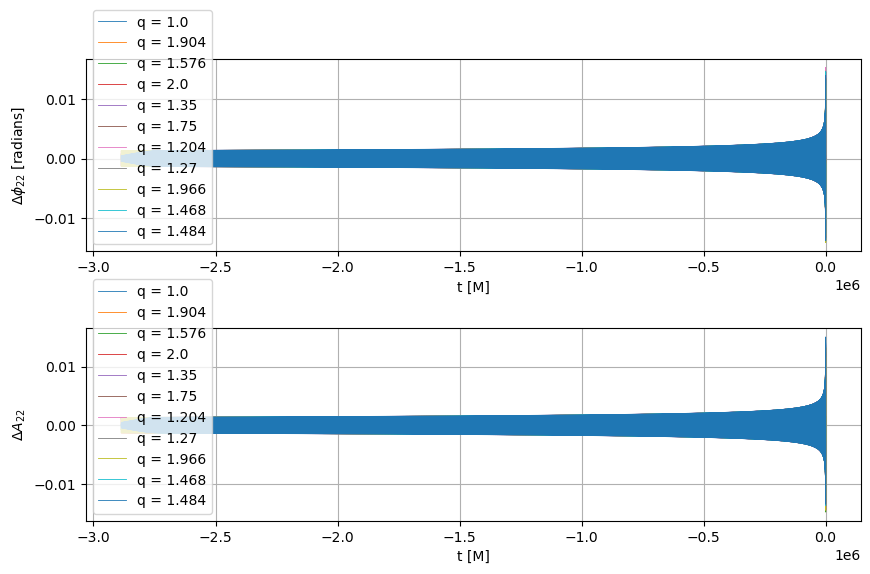

In [48]:
fig_dataset_q, axs = plt.subplots(2, figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)

hp_TS_read = hp_TS_read/np.linalg.norm(hp_TS_read)
hc_TS_read = hc_TS_read/np.linalg.norm(hc_TS_read)

hp_TS_read = hp_TS_read / np.linalg.norm(hp_TS_read, axis=1, keepdims=True)
hc_TS_read = hc_TS_read / np.linalg.norm(hc_TS_read, axis=1, keepdims=True)


q = np.array([1.0, 1.904, 1.576, 2.0, 1.35, 1.75, 1.204, 1.27, 1.966, 1.468, 1.484])

for i in range(len(hp_TS_read)):
    axs[0].plot(t_read[i], hp_TS_read[i], label = 'q = {}'.format(q[i]), linewidth=0.6)
    axs[0].set_xlabel('t [M]')
    axs[0].set_ylabel('$\Delta\phi_{22}$ [radians]')
    axs[0].grid()
    # axs[0].set_xlim(-7.6e6, -7.4e6)
    # axs[0].set_ylim(0.00024, 0.00026)
    axs[0].legend(loc = 'lower left')
    
    axs[1].plot(t_read[i], hc_TS_read[i], label = 'q = {}'.format(q[i]), linewidth=0.6)
    axs[1].set_ylabel('$\Delta A_{22}$')
    # axs[1].set_ylim(-0.5e-23, 0.5e-23)
    
    # axs[1].set_xlim(-50000, 0)
    axs[1].set_xlabel('t [M]')
    axs[1].grid()
    axs[1].legend(loc = 'lower left')
    
    figname = 'hp_hc_q.png'
    fig_dataset_q.savefig('Images/' + figname)
    # print(D_phase_read[0])
    # if D_phase_read[0] == D_phase_read[1]:
    #     print(t_M_read[i][0])
    
plt.show()

In [49]:
q = q.reshape((q.shape[0], 1))

# normalized_wfs = hp_TS_ds[0] / np.linalg.norm(hp_TS_ds[0], axis=1, keepdims=True)
reduced_basis, greedy_points, greedy_error, projections = greedy_algorithm(q, hc_TS_read, 1e-12)

0.031057043520285706
0.030574900204722404
0.03056886527640328
0.03042915744097992
0.029626150806081775
0.026412890934382836
0.022359732621217977
0.02162793514781503
0.01894460293049137


In [14]:
reduced_basis, greedy_points, greedy_error, projections = greedy_algorithm(q, hp_TS_read, 1e-12)


3.886867613799692e-23


### Visualising reduced basis and greedy error with seed from parameter space (not training set)

In [44]:
# 200 values between 0 <= eccentricity <=0.1 with steps of 0.01
parameter_space = np.linspace(0.01, 0.1, num=200) # Lower eccentricities cause phase problems so start from 0.01

# The training set consist of 10 waveforms (vectorarrays) and represent the solutions of our parameterspace.
parameter_values_T = eccmin # 20 values between 0 <= eccentricity <=0.1 with steps of 0.01
# training_set = D_phase_read
training_set = D_phase_read[-1000:]
# print(training_set.shape, training_set)

# The easiest option to get a reduced basis is to use the training set
trivial_basis = training_set.copy()



#### Test reduced basis for 1 random vector V

In [59]:
# Solution vector from randomly picked parameter value within parameter space
random_parameter = random.choice(parameter_space)
D_phase, D_amp, t_M_short = phase_amp_diff(10, 1, random_parameter, amp_circ, phase_circ, t_M_circ) 

# Give random solution vector same length as vectors in training set
len_T_wfs = len(training_set[0])
D_phase = D_phase[-len_T_wfs:]

# Normalise vector
D_phase = D_phase / np.linalg.norm(D_phase) 
# print(np.linalg.norm(D_phase))

random_V = D_phase

time : SimInspiral_M_independent ecc = 0.02412060301507538 0.36761968999999983  minutes


We want to know how good are reduced basis is as representation of the parameter space. To find out we compute:
$$
inf_{v \in V_N} ||u(\mu) - v ||,
$$

where $V_N$ denotes the span of the reduced basis, for all randomy picked $\mu$ that we used to build the reduced basis. The span of a set of vectors is all linear combinations of these vectors. Think about vector (0,1) and (1,0), a span of these two vectors would be the whole x-y plane

We can compute the infimum by using the orthogonal projection onto $V_N$. The best-approximation error can then be found by taking the norm of the  difference between $u(\mu)$ and the orthogonal projection. 



Add another part on $$ G \cdot \Lambda = R $$

In [48]:
# Gramian matrix calculated by taking the Euclidean inner product 
G = np.dot(trivial_basis, trivial_basis.T)
# print(G)

[[1.         0.99267967 0.98300015 0.98454339 0.98221137 0.98016242
  0.97728642 0.97699359 0.97389521 0.97274677]
 [0.99267967 1.         0.99796561 0.99847569 0.99768643 0.99690966
  0.99571079 0.99558255 0.99416314 0.99361077]
 [0.98300015 0.99796561 1.         0.99995717 0.99998638 0.99988504
  0.99957782 0.99953708 0.99901163 0.99877697]
 [0.98454339 0.99847569 0.99995717 1.         0.99991425 0.99972186
  0.9992942  0.99924188 0.99859563 0.99831808]
 [0.98221137 0.99768643 0.99998638 0.99991425 1.         0.99994147
  0.99969433 0.99965964 0.99919423 0.99898099]
 [0.98016242 0.99690966 0.99988504 0.99972186 0.99994147 1.
  0.99990016 0.99987987 0.999564   0.99940392]
 [0.97728642 0.99571079 0.99957782 0.9992942  0.99969433 0.99990016
  1.         0.9999979  0.99987944 0.99978962]
 [0.97699359 0.99558255 0.99953708 0.99924188 0.99965964 0.99987987
  0.9999979  1.         0.99990005 0.999817  ]
 [0.97389521 0.99416314 0.99901163 0.99859563 0.99919423 0.999564
  0.99987944 0.9999000

In [49]:
# Compute all Euclidean inner products between the vectors in the trivial basis and our randomly sampled solution vector V
R = np.dot(trivial_basis, random_V)
print(R)

[0.97746986 0.99579037 0.99960218 0.99932648 0.99971507 0.99991158
 0.99999807 0.99999601 0.99986536 0.99977111]


In [229]:
# Calculate coefficients
lambdas = np.linalg.solve(G, R)
print(lambdas)

[-0.00220317  0.00448201  0.0296407   0.12454132  0.05803055  0.0842825
  0.17093289  0.13870639  0.19764667  0.1940989 ]


In [84]:
print(lambdas.shape, trivial_basis.shape)

(10,) (10, 1739176)


In [39]:
def linear_combination(basis_vectors, coefficients):
    # Perform linear combination
    lincomb = np.zeros((basis_vectors.shape[0], basis_vectors.shape[1]))
    lincomb_j = 0
    
    for i in range(len(coefficients)):
        for j in range(coefficients.shape[1]):
            lincomb_j += coefficients[i][j] * basis_vectors[:, i]
        lincomb[:, i] = lincomb_j
        
    return lincomb

In [200]:
 
array = np.array([[1, 2, 3, 4], [4, 5, 6, 7], [7, 8, 9, 10]])
coeffs = np.array([[1, 2, 3], [1, 1, 1]])
# print(linear_combination(trivial_basis, random_Vs))
# print(linear_combination(array, coeffs))

# Linear combination of the trivial basis and the coefficients

lambdas = lambdas.reshape((lambdas.shape[0], 1))
V_proj = linear_combination(trivial_basis, lambdas)
# print(V_proj.shape, random_V.shape)

# Best approximation error
residual = random_V.T - V_proj
print(residual)

[[3.69033967e-05 3.51441184e-05 2.35587914e-05 ... 1.14682546e-03
  1.14718073e-03 1.14762392e-03]
 [3.64518392e-05 3.56113549e-05 3.01033747e-05 ... 1.14682546e-03
  1.14718073e-03 1.14762392e-03]
 [3.62226564e-05 3.58483327e-05 3.34226951e-05 ... 1.14682546e-03
  1.14718073e-03 1.14762392e-03]
 ...
 [3.61146863e-05 3.59600763e-05 3.49878975e-05 ... 1.14682546e-03
  1.14718073e-03 1.14762392e-03]
 [3.60653166e-05 3.60111138e-05 3.57027720e-05 ... 1.14682546e-03
  1.14718073e-03 1.14762392e-03]
 [3.60430942e-05 3.60491316e-05 3.61378677e-05 ... 1.14682546e-03
  1.14718073e-03 1.14762392e-03]]


#### Test reduced basis for validation set of vectors

In [45]:
# Validation set of 5 randomly picked parameter values from the parameter space
validation_set = random.sample(list(parameter_space), 5)
print(validation_set)
# Solution space of randomly picked validation set
random_Vs = np.zeros((len(validation_set), (len(trivial_basis[0]))))

for count, random_parameter in enumerate(validation_set):
    D_phase, D_amp, t_M_short = phase_amp_diff(10, 1, random_parameter, amp_circ, phase_circ, t_M_circ) # Highest eccentricity causes shortest inspiral-time.
    
    # Give random solution vector same length as waveforms in training set
    len_T_wfs = len(training_set[0])
    D_phase = D_phase[-len_T_wfs:]
    # D_amp = D_amp[-len_T_wfs:]

    # Normalise vector
    D_phase = D_phase / np.linalg.norm(D_phase) 
    # D_amp = D_amp / np.linalg.norm(D_amp) 

    random_Vs[count] = D_phase
    # random_Vs[count] = D_amp

print(random_Vs, random_Vs.shape)




[0.07557788944723619, 0.08869346733668342, 0.08507537688442211, 0.06155778894472363, 0.07964824120603016]
time : SimInspiral_M_independent ecc = 0.07557788944723619 0.5915780516666624  minutes
time : SimInspiral_M_independent ecc = 0.08869346733668342 0.47596947666665984  minutes
time : SimInspiral_M_independent ecc = 0.08507537688442211 0.457316143333325  minutes
time : SimInspiral_M_independent ecc = 0.06155778894472363 0.5072458616666609  minutes
time : SimInspiral_M_independent ecc = 0.07964824120603016 0.5852886283333343  minutes
[[2.39790136e-05 2.39890477e-05 2.39990921e-05 ... 1.14898086e-03
  1.14923328e-03 1.14954728e-03]
 [2.00177874e-05 2.00164796e-05 2.00152377e-05 ... 1.14962413e-03
  1.14981924e-03 1.15006693e-03]
 [2.56390329e-05 2.56313053e-05 2.56235345e-05 ... 1.14900543e-03
  1.14923337e-03 1.14952209e-03]
 [4.54702328e-05 4.54620421e-05 4.54539261e-05 ... 1.14201244e-03
  1.14229432e-03 1.14265505e-03]
 [4.21520744e-05 4.21575835e-05 4.21630426e-05 ... 1.14021238e-

In [101]:
def are_linearly_independent(vectors):
    """
    Check if a set of vectors are linearly independent.
    
    Args:
    vectors (numpy.ndarray): Matrix where each row represents a vector.
    
    Returns:
    bool: True if the vectors are linearly independent, False otherwise.
    """
    rank_original = np.linalg.matrix_rank(vectors)
    rank_stacked = np.linalg.matrix_rank(np.hstack((vectors, np.zeros((vectors.shape[0], 1)))))
    return rank_original == rank_stacked


result = are_linearly_independent(trivial_basis)
print("Vectors are linearly independent:", result)

Vectors are linearly independent: True


In [46]:
def compute_proj_errors(basis, V, reg=1e-6):
    """
    Computes the projection errors when approximating target vectors V 
    using a given basis.

    Parameters:
    - basis (numpy.ndarray): The basis vectors used for projection.
    - V (numpy.ndarray): The target vectors to be approximated.
    - reg (float, optional): Regularization parameter to stabilize the computation
      (default is 1e-6).

    Returns:
    - errors (list): List of projection errors for each number of basis vectors
    """
    
    G = np.dot(basis, basis.T) + reg * np.eye(basis.shape[0]) # The gramian matrix of the inner product with itself 
    # In some cases this is a singular matrix and will cause computational problems. To prevent this, I added a small regulation to the diagonal terms of the matrix.
    R = np.dot(basis, V.T)
    errors = []
    
    for N in range(basis.shape[0] + 1):
        if N > 0:
            v = np.linalg.solve(G[:N, :N], R[:N, :])
            V_proj = np.dot(v.T, basis[:N, :])
        else:
            V_proj = np.zeros_like(V)
        errors.append(np.max(np.linalg.norm(V - V_proj, axis=1, ord=2)))
    return errors

errors = compute_proj_errors(trivial_basis, random_Vs)
print("Projection errors:", errors)

Projection errors: [1.0000000000000007, 0.2207368462363906, 0.010864873430063825, 0.01049221685689842, 0.00427087434041902, 0.0025276715719266462, 0.0021166351928524167, 0.0017780056174909952, 0.0015017898650233953, 0.0014925266917302962, 0.001444454216141505, 0.0014185802514031297, 0.0013243340687230467, 0.0013185182726619588, 0.0012302912092998749, 0.0011223459447769902, 0.0010715136675907757, 0.0010679228693895567, 0.001029938473409874, 0.0010082530233564858, 0.000976849648630202]


In [47]:

def strong_greedy(U, N, param_space, reg=1e-6):
    """
    Perform strong greedy selection to arrange the training set from least similar to most similar.

    Parameters:
    - U (numpy.ndarray): Training set, each row represents a data point.
    - N (int): Number of basis vectors to select.
    - param_space (numpy.ndarray): Parameters corresponding to each data point in U.
    - reg (float, optional): Regularization parameter to stabilize computation (default is 1e-6).

    Returns:
    - basis (numpy.ndarray): Selected basis vectors arranged from least to most similar to the training set.
    - parameters (list): Parameters corresponding to the selected basis vectors.
    """
    
    basis = np.empty((0, U.shape[1]))  # Initialize an empty array for the basis
    parameters = []  # Initialize an empty array for the parameters of reduced basis

    for n in range(N):
        # Compute projection errors. # The gramian matrix of the inner product with itself 
    # In some cases this is a singular matrix and will cause computational problems. To prevent this, I added a small regulation to the diagonal terms of the matrix.
        G = np.dot(basis, basis.T) + reg * np.eye(basis.shape[0]) if basis.size > 0 else np.zeros((0, 0))  # Compute Gramian
        R = np.dot(basis, U.T)  # Compute inner product
        lambdas = np.linalg.lstsq(G, R, rcond=None)[0] if basis.size > 0 else np.zeros((0, U.shape[0]))  # Use pseudoinverse
        U_proj = np.dot(lambdas.T, basis) if basis.size > 0 else np.zeros_like(U)  # Compute projection
        errors = np.linalg.norm(U - U_proj, axis=1)  # Calculate errors
    
        # Extend basis
        basis = np.vstack([basis, U[np.argmax(errors)]])
        parameters.append(param_space[np.argmax(errors)])
    # print(parameters)
    return basis, parameters


N = 20  # Number of vectors to select for the basis

U = training_set.copy()
greedy_basis, parameters_gb = strong_greedy(U, N, eccmin)

greedy_errors = compute_proj_errors(greedy_basis, random_Vs)
print("Greedy errors:", greedy_errors)
print("Selected basis shape:", len(greedy_errors), len(errors))

Greedy errors: [1.0000000000000007, 0.021013459350907374, 0.001976503193689166, 0.001974041046786111, 0.001911987995289499, 0.0017829851532771405, 0.0017288480208222344, 0.0016185187312078985, 0.001532605663875855, 0.0014987462738303963, 0.0014886158598183849, 0.0014462732961185562, 0.0013380131695818875, 0.0013185182726578495, 0.0012302912092933733, 0.0011223459447749712, 0.0010715136675809999, 0.0010679228693854812, 0.0010323888869690073, 0.0009950247471610357, 0.0009768496486367232]
Selected basis shape: 21 21


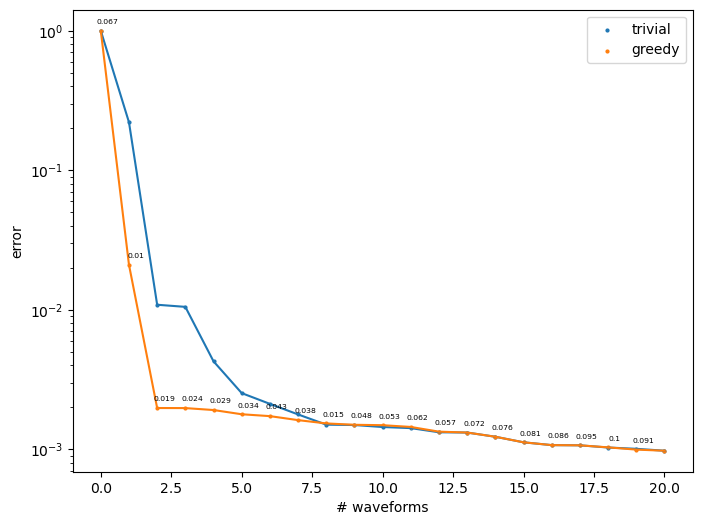

In [48]:
fig_greedy_error = plt.figure(figsize=(8,6))


N_basis_vectors = np.linspace(0, 20, num=21)

plt.scatter(N_basis_vectors, errors, label='trivial', s=4)
plt.plot(N_basis_vectors, errors)
plt.scatter(N_basis_vectors, greedy_errors, label='greedy', s=4)

# Annotate each point with its label
for i, label in enumerate(parameters_gb):
    plt.annotate(label, (N_basis_vectors[i], greedy_errors[i]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=5.5)

    
plt.plot(N_basis_vectors, greedy_errors)

plt.xlabel('# waveforms')
plt.ylabel('error')
plt.yscale('log')
plt.legend()
plt.show()

figname = 'Greedy_error_20wfs_0.01_0.1_phase_cutoff.png'
fig_greedy_error.savefig('Images/Greedy_errors/' + figname)

In [ ]:
print('Highest error of best approximation of the basis: ', np.min(greedy_errors))

In [28]:
print('Highest error of best approximation of the basis: ', np.min(greedy_errors), 'cut-off dataset 10000?')

Highest error of best approximation of the basis:  0.00035894607542710615 cut-off dataset


In [67]:
print('Highest error of best approximation of the basis: ', np.min(greedy_errors), '8000')

Highest error of best approximation of the basis:  0.00035894607542710615


In [28]:
import numpy as np
# print(training_set)
training_set = D_amp_read

def gram_schmidt(basis):
    num_vectors = basis.shape[0]
    ortho_basis = np.zeros_like(basis)
    
    for i in range(num_vectors):
        vector = basis[i]
        projection = np.zeros_like(vector)
        for j in range(i):
            projection += np.dot(basis[i], ortho_basis[j]) * ortho_basis[j]
        ortho_vector = vector - projection
        ortho_basis[i] = ortho_vector / np.linalg.norm(ortho_vector)
    
    return ortho_basis

orthonormal_basis = gram_schmidt(training_set)
print(orthonormal_basis.shape, training_set.shape)
print("Orthonormal basis:\n", orthonormal_basis)


(20, 1526125) (20, 1526125)
Orthonormal basis:
 [[-2.80330275e-04 -2.80189360e-04 -2.80032957e-04 ...  6.20666833e-02
  -5.75769036e-03 -6.08237088e-02]
 [ 7.36751400e-04  7.44153663e-04  7.51518714e-04 ... -2.46577963e-02
   4.64020813e-02  1.04265478e-01]
 [-8.23481891e-04 -8.26965577e-04 -8.30409636e-04 ... -5.14258522e-03
   1.00243159e-02  2.22766525e-02]
 ...
 [-4.14437153e-04 -4.15197565e-04 -4.15921036e-04 ...  2.76770561e-04
  -1.09057112e-04 -4.06283455e-04]
 [-2.35713669e-04 -2.37146116e-04 -2.38548987e-04 ...  4.62570799e-04
   2.31449370e-04  2.13395510e-05]
 [-2.53951032e-04 -2.56131363e-04 -2.58286834e-04 ...  8.44890798e-04
   5.91432170e-03  1.00367958e-02]]


In [ ]:
fig_dataset_ecc, axs = plt.subplots(2, figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)
                                           

for i in range(len(t_M_read)):
    axs[0].plot(t_M_read[i], D_phase_read[i], label = 'e = {}'.format(eccmin[i]), linewidth=0.6)
    axs[0].set_xlabel('t [M]')
    # axs[0].set_ylabel('$\Delta\phi_{22}$ [radians]')
    axs[0].set_ylabel('$\Delta A_{22}$')
    axs[0].grid()
    # axs[0].set_xlim(-7.6e6, -7.4e6)
    axs[0].set_ylim(-0.5e-2, 0.5e-2)
    
    legend = axs[0].legend(loc='lower left', ncol=7)
    
    for text in legend.get_texts():
        text.set_fontsize(8)
    
    axs[1].plot(t_M_read[i], orthonormal_basis[i], label = 'e = {}'.format(eccmin[i]), linewidth=0.6)
    axs[1].set_ylabel('$\Delta A_{22}$')
    axs[1].set_ylim(-0.5e-2, 0.5e-2)
    
    # axs[1].set_xlim(-50000, 0)
    axs[1].set_xlabel('t [M]')
    axs[1].grid()
    
    # Get the legend of the first subplot
    legend = axs[1].legend(loc='lower left', ncol=7)

    for text in legend.get_texts():
        text.set_fontsize(8)

    
    figname = 'Damp22_lowecc_RB.png'
    fig_dataset_ecc.savefig('Images/' + figname)
    # print(D_phase_read[0])
    # if D_phase_read[0] == D_phase_read[1]:
    #     print(t_M_read[i][0])
    
plt.show()

# Reduced basis

/home/suzannelexmond/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


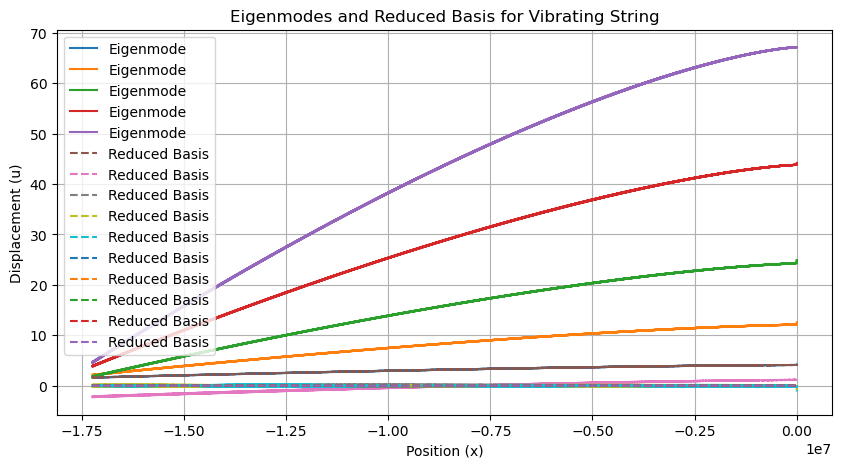

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0  # Length of the string
N = 100  # Number of spatial points
c = 1.0  # Wave speed
dt = 0.001  # Time step
T = 2.0  # Total simulation time

# Discretization
dx = L / (N - 1)
x = np.linspace(0, L, N)
u = np.zeros(N)  # Initial displacement
v = np.zeros(N)  # Initial velocity

# Finite Difference Method (FDM) solver
def solve_wave_equation(u, v, c, dt, N):
    for t in np.arange(0, T, dt):
        u_old = u.copy()
        v_old = v.copy()
        for i in range(1, N - 1):
            u[i] = 2 * u_old[i] - u[i] + c**2 * dt**2 / dx**2 * (u_old[i+1] - 2 * u_old[i] + u_old[i-1])
        v = (u - u_old) / dt
        u[0] = u[-1] = 0  # Boundary conditions (fixed ends)
    return u

# Compute eigenmodes using Gram-Schmidt orthogonalization
def compute_reduced_basis(u_modes, num_modes):
    basis = np.zeros_like(u_modes)
    basis[0] = u_modes[0]
    for i in range(1, num_modes):
        basis[i] = u_modes[i]
        for j in range(i):
            basis[i] -= np.dot(u_modes[i], basis[j]) / np.dot(basis[j], basis[j]) * basis[j]
    return basis

# Solve the wave equation and compute eigenmodes
u_modes = []
for i in range(10):  # Compute first 10 eigenmodes
    u = np.random.rand(N)  # Random initial displacement
    u = solve_wave_equation(u, np.zeros(N), c, dt, N)
    u_modes.append(u)


# Compute the reduced basis using Gram-Schmidt orthogonalization
num_modes = 5  # Number of modes to keep in the reduced basis
reduced_basis = compute_reduced_basis(D_phase_read, num_modes)

# Plot the first few eigenmodes and the reduced basis
plt.figure(figsize=(10, 5))
# print(u_modes, len(u_modes))
for mode in D_phase_read[:num_modes]:
    plt.plot(t_M_read[0], mode, label='Eigenmode')
for mode in reduced_basis:
    plt.plot(t_M_read[0], mode, linestyle='--', label='Reduced Basis')
plt.xlabel('Position (x)')
plt.ylabel('Displacement (u)')
plt.title('Eigenmodes and Reduced Basis for Vibrating String')
plt.legend()
plt.grid(True)
plt.show()

/home/suzannelexmond/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


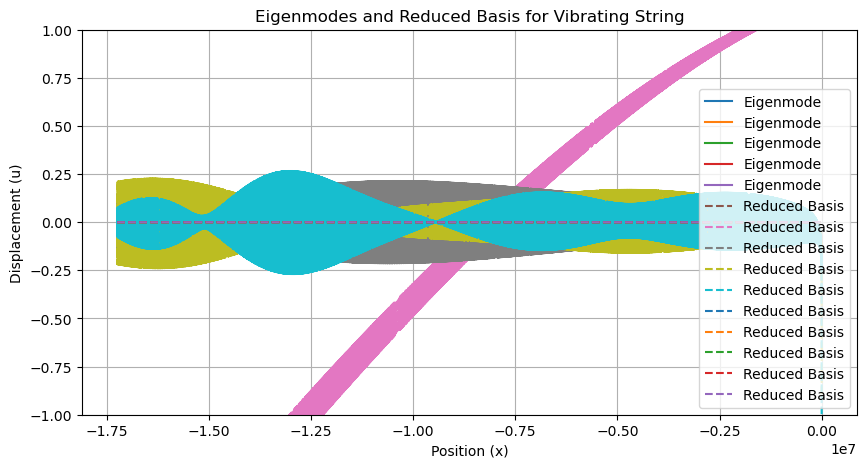

In [108]:

# Plot the first few eigenmodes and the reduced basis
plt.figure(figsize=(10, 5))
# print(u_modes, len(u_modes))
for mode in D_phase_read[:num_modes]:
    plt.plot(t_M_read[0], mode, label='Eigenmode')
for mode in reduced_basis:
    plt.plot(t_M_read[0], mode, linestyle='--', label='Reduced Basis')
plt.xlabel('Position (x)')
plt.ylabel('Displacement (u)')
plt.title('Eigenmodes and Reduced Basis for Vibrating String')
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.show()

/home/suzannelexmond/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


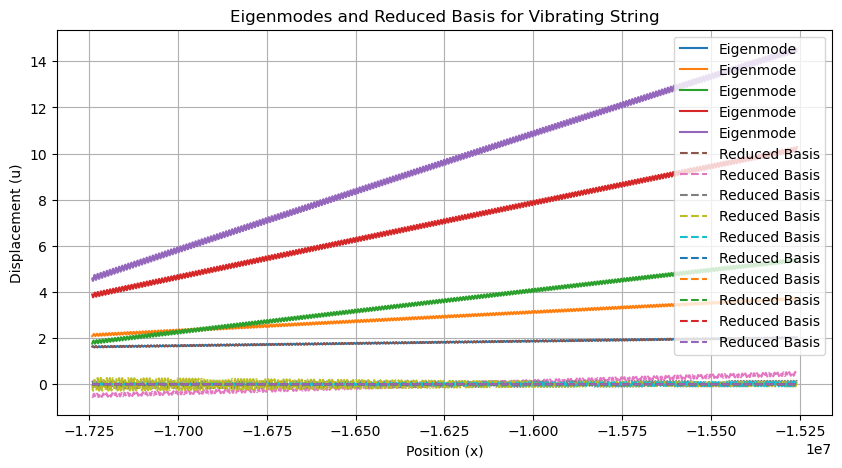

In [111]:
D_test = D_phase_read[:, :200000]
# Compute the reduced basis using Gram-Schmidt orthogonalization
num_modes = 5  # Number of modes to keep in the reduced basis
reduced_basis = compute_reduced_basis(D_test, num_modes)

# Plot the first few eigenmodes and the reduced basis
plt.figure(figsize=(10, 5))
# print(u_modes, len(u_modes))
for mode in D_test[:num_modes]:
    plt.plot(t_M_read[0][:200000], mode, label='Eigenmode')
for mode in reduced_basis:
    plt.plot(t_M_read[0][:200000], mode, linestyle='--', label='Reduced Basis')
plt.xlabel('Position (x)')
plt.ylabel('Displacement (u)')
plt.title('Eigenmodes and Reduced Basis for Vibrating String')
plt.legend()
plt.grid(True)
plt.show()

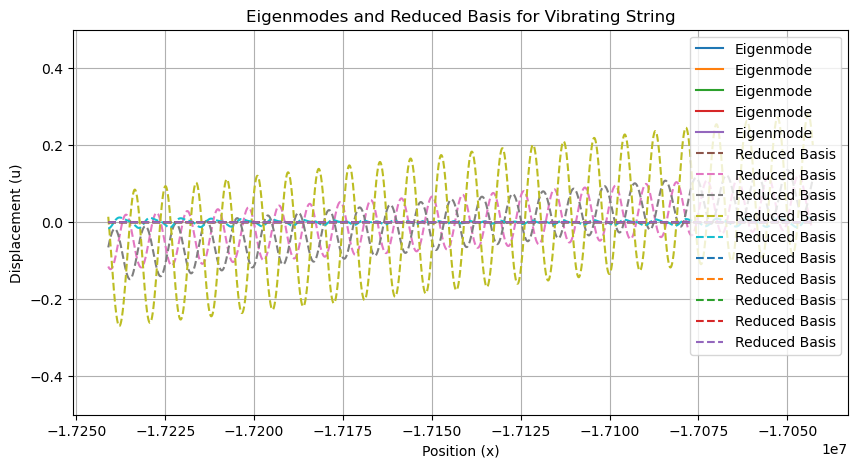

In [110]:
# Plot the first few eigenmodes and the reduced basis
plt.figure(figsize=(10, 5))
# print(u_modes, len(u_modes))
for mode in D_test[:num_modes]:
    plt.plot(t_M_read[0][:200000], mode, label='Eigenmode')
for mode in reduced_basis:
    plt.plot(t_M_read[0][:200000], mode, linestyle='--', label='Reduced Basis')
plt.xlabel('Position (x)')
plt.ylabel('Displacement (u)')
plt.ylim(-0.5, 0.5)
plt.title('Eigenmodes and Reduced Basis for Vibrating String')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Define function to solve wave equation for a given parameter
def solve_wave_equation_for_parameter(param):
    # Parameters for wave equation solver
    L = 1.0  # Length of the string
    N = 100  # Number of spatial points
    c = 1.0  # Wave speed
    dt = 0.001  # Time step
    T = 2.0  # Total simulation time

    # Discretization
    dx = L / (N - 1)
    x = np.linspace(0, L, N)
    u = np.zeros(N)  # Initial displacement
    v = np.zeros(N)  # Initial velocity

    # Finite Difference Method (FDM) solver
    for t in np.arange(0, T, dt):
        u_old = u.copy()
        v_old = v.copy()
        for i in range(1, N - 1):
            u[i] = 2 * u_old[i] - u[i] + c**2 * dt**2 / dx**2 * (u_old[i+1] - 2 * u_old[i] + u_old[i-1])
        v = (u - u_old) / dt
        u[0] = u[-1] = 0  # Boundary conditions (fixed ends)
    return u

# Define function to compute Gram-Schmidt orthogonalization
def compute_orthogonal_basis(u_modes, num_modes):
    basis = np.zeros_like(u_modes)
    basis[0] = u_modes[0]
    for i in range(1, num_modes):
        basis[i] = u_modes[i]
        for j in range(i):
            basis[i] -= np.dot(u_modes[i], basis[j]) / np.dot(basis[j], basis[j]) * basis[j]
    return basis

# Define function to compute features from reduced basis
def compute_features(u, reduced_basis):
    return np.dot(u, reduced_basis.T)

# Parameters
num_examples = 10
parameter_space = np.linspace(0.1, 1.0, num_examples)  # Example parameter space
outcome_function = lambda param: param ** 2  # Example outcome function

# Step 1: Generate dataset
dataset = []
for param in parameter_space:
    outcome = outcome_function(param)
    dataset.append((param, outcome))
dataset = np.array(dataset)

# Extract features and outcomes from the dataset
X = dataset[:, 0].reshape(-1, 1)  # Features (parameters)
y = dataset[:, 1]  # Outcomes

# Step 2: Compute reduced basis (eigenmodes) using Gram-Schmidt orthogonalization
def compute_reduced_basis(dataset, num_modes):
    u_modes = []
    for param, _ in dataset:
        # Solve physics problem and compute eigenmodes
        u = solve_wave_equation_for_parameter(param)
        u_modes.append(u)
    reduced_basis = compute_orthogonal_basis(u_modes, num_modes)
    return reduced_basis

# Step 3: Extract reduced basis features
num_modes = 5  # Number of modes to keep in the reduced basis
reduced_basis = compute_reduced_basis(dataset, num_modes)
X_reduced = np.array([compute_features(u, reduced_basis) for u in u_modes])

# Step 4: Train machine learning model with imputation
imputer = SimpleImputer(strategy='median')  # Change imputation strategy to median
X_train_imputed = imputer.fit_transform(X_train)
model = LinearRegression()
model.fit(X_train_imputed, y_train)

import matplotlib.pyplot as plt

# Step 5: Predict outcomes for training and test sets with imputation
train_predictions = model.predict(X_train_imputed)
test_predictions = model.predict(X_test)

# Plot training set predictions
plt.figure(figsize=(10, 5))
plt.scatter(y_train, train_predictions, color='blue', label='Training set')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect predictions')
plt.xlabel('True Outcomes')
plt.ylabel('Predicted Outcomes')
plt.title('Linear Regression: Training Set Predictions')
plt.legend()
plt.grid(True)
plt.show()

# Plot test set predictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test, test_predictions, color='green', label='Test set')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect predictions')
plt.xlabel('True Outcomes')
plt.ylabel('Predicted Outcomes')
plt.title('Linear Regression: Test Set Predictions')
plt.legend()
plt.grid(True)
plt.show()

# Empirical interpolation method

In [43]:
RB_3 = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])
RB_2 = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
print(RB_3.shape)

T2 = np.array([0, 2])
T3 = np.array([0, 2, 4])
time_domain = np.array([0.01,0.02, 0.03, 0.04, 0.05])
waveform = np.array([0.11,0.22, 0.33, 0.44, 0.55])

def EI(waveform, reduced_basis, T):

    B_j_vec = np.zeros((reduced_basis.shape[1], reduced_basis.shape[0]))
    empirical_interpolant = 0

    V = np.zeros((len(reduced_basis), len(reduced_basis)))
    for j in range(len(reduced_basis)):
        for i in range(len(T)):
            # print(reduced_basis[i], T[j])
            V[j][i] = reduced_basis[i][T[j]]

    for j in range(V.shape[1]): 
        B_j = 0
        for i in range(len(reduced_basis)):
            B_j += reduced_basis[i].T * np.linalg.inv(V)[i][j]

        B_j_vec[:, j] = B_j
    
    for j in range(reduced_basis.shape[0]):
        empirical_interpolant += B_j_vec[:, j]*waveform[j]

    return empirical_interpolant

# EI(waveform, RB, T)
# print('done')


def EIM(reduced_basis, time_samples):
    i = np.argmax(reduced_basis[0])
    empirical_interpolant = np.zeros(len(reduced_basis))
    
    T1 = time_samples[i]
    emp_nodes = [T1]
    emp_nodes_idx = [i]

    for j in range(1, reduced_basis.shape[0]):
        print(j, reduced_basis[j].T, reduced_basis[:j], emp_nodes_idx)
        empirical_interpolant = EI(reduced_basis[j].T, reduced_basis[:j], emp_nodes_idx)
        print('EI', empirical_interpolant)
        r = empirical_interpolant - reduced_basis[j][:, np.newaxis].T
        print('r', r)
        idx = np.argmax(np.abs(r))

        emp_nodes.append(time_samples[idx])
        emp_nodes_idx.append(idx)

    return emp_nodes

print('RB_2 :', EIM(RB_2, time_domain), '\n\n')
print(EIM(RB_3, time_domain))

(2, 5) (5,)
[-0.0]
